Real network loaded:
Number of nodes: 7610
Number of edges: 15751
Density: 0.000544

Training VGAE model...
Epoch 20/200, Loss: 1055.7960
Epoch 40/200, Loss: 731.1306
Epoch 60/200, Loss: 719.1757
Epoch 80/200, Loss: 717.8914
Epoch 100/200, Loss: 718.3068
Epoch 120/200, Loss: 718.9388
Epoch 140/200, Loss: 718.2882
Epoch 160/200, Loss: 717.5487
Epoch 180/200, Loss: 718.0397
Epoch 200/200, Loss: 717.8636

Generating synthetic network (this may take a few minutes)...
Target: 7610 nodes, 15751 edges

Synthetic network generated:
Number of nodes: 7610
Number of edges: 15751
Density: 0.000544

Comparison of Real and Synthetic Networks
Metric                                 Real    Synthetic     Diff %
----------------------------------------------------------------------
num_nodes                              7610         7610
num_edges                             15751        15751
density                              0.0005       0.0005      0.00%
avg_degree                           4.1396

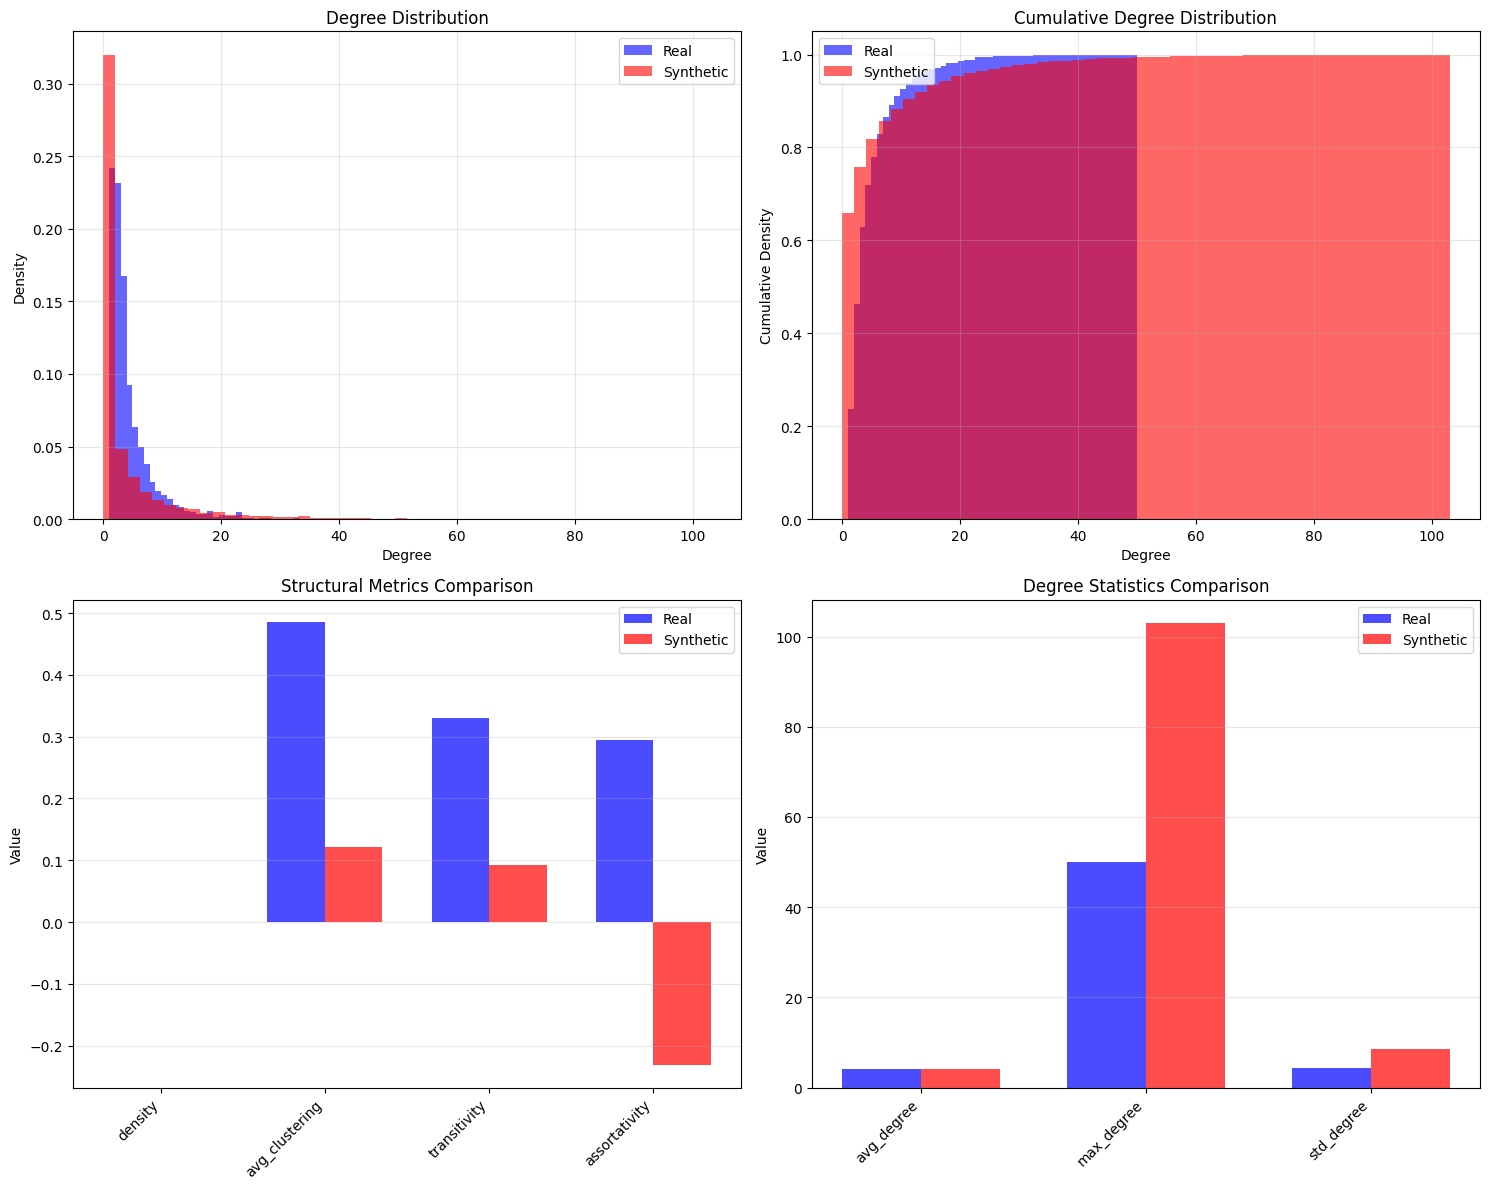

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import networkx as nx
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, x, adj):
        support = torch.mm(x, self.weight)
        output = torch.spmm(adj, support)
        return output

class VGAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, latent_dim=16):
        super(VGAE, self).__init__()

        self.gc1 = GCNLayer(input_dim, hidden_dim)
        self.gc_mu = GCNLayer(hidden_dim, latent_dim)
        self.gc_logvar = GCNLayer(hidden_dim, latent_dim)

    def encode(self, x, adj):
        hidden = F.relu(self.gc1(x, adj))
        mu = self.gc_mu(hidden, adj)
        logvar = self.gc_logvar(hidden, adj)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return torch.sigmoid(torch.mm(z, z.t()))

    def forward(self, x, adj):
        mu, logvar = self.encode(x, adj)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_adj, adj, mu, logvar, num_nodes):
    BCE = F.binary_cross_entropy(recon_adj.view(-1), adj.to_dense().view(-1), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (BCE + KLD) / num_nodes

def prepare_graph_data(G, num_nodes=1000):
    if G.number_of_nodes() > num_nodes:
        nodes = list(G.nodes())[:num_nodes]
        G = G.subgraph(nodes).copy()

    G = nx.convert_node_labels_to_integers(G)

    adj = nx.adjacency_matrix(G)
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    features = np.eye(G.number_of_nodes())

    adj_tensor = torch.FloatTensor(adj.toarray())
    adj_sparse = torch.sparse_coo_tensor(
        torch.LongTensor(np.array(adj.nonzero())),
        torch.FloatTensor(adj.data),
        torch.Size(adj.shape)
    )

    adj_norm = normalize_adj(adj_sparse)
    features_tensor = torch.FloatTensor(features)

    return adj_norm, features_tensor, adj_tensor, G.number_of_nodes()

def normalize_adj(adj):
    adj = adj + torch.sparse_coo_tensor(
        torch.LongTensor([[i for i in range(adj.size(0))], [i for i in range(adj.size(0))]]),
        torch.ones(adj.size(0)),
        adj.size()
    )

    rowsum = torch.sparse.sum(adj, dim=1).to_dense()
    d_inv_sqrt = torch.pow(rowsum, -0.5)
    d_inv_sqrt[torch.isinf(d_inv_sqrt)] = 0.

    indices = adj.coalesce().indices()
    values = adj.coalesce().values()

    row_indices = indices[0]
    col_indices = indices[1]

    new_values = values * d_inv_sqrt[row_indices] * d_inv_sqrt[col_indices]

    return torch.sparse_coo_tensor(indices, new_values, adj.size())

def train_vgae(G, epochs=200, hidden_dim=32, latent_dim=16):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    adj_norm, features, adj_label, num_nodes = prepare_graph_data(G, num_nodes=1000)

    adj_norm = adj_norm.to(device)
    features = features.to(device)
    adj_label = adj_label.to(device)

    model = VGAE(features.size(1), hidden_dim, latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        recon_adj, mu, logvar = model(features, adj_norm)
        loss = loss_function(recon_adj, adj_label, mu, logvar, num_nodes)

        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

    return model, losses

def generate_graph_batch(model, num_nodes, target_edges=15000, batch_size=1000, device='cpu'):
    model.eval()

    print(f"Target: {num_nodes} nodes, {target_edges} edges")

    with torch.no_grad():
        z = torch.randn(num_nodes, model.gc_mu.weight.size(1)).to(device)

        edge_probs = []

        for i in range(0, num_nodes, batch_size):
            end_i = min(i + batch_size, num_nodes)
            z_i = z[i:end_i]

            for j in range(0, num_nodes, batch_size):
                end_j = min(j + batch_size, num_nodes)

                if i <= j:
                    z_j = z[j:end_j]
                    probs = torch.sigmoid(torch.mm(z_i, z_j.t())).cpu().numpy()

                    if i == j:
                        for k in range(probs.shape[0]):
                            for l in range(k):
                                edge_probs.append((probs[k, l], i + k, j + l))
                    else:
                        for k in range(probs.shape[0]):
                            for l in range(probs.shape[1]):
                                edge_probs.append((probs[k, l], i + k, j + l))

        edge_probs.sort(reverse=True)

        adj_full = np.zeros((num_nodes, num_nodes))
        for idx in range(min(target_edges, len(edge_probs))):
            prob, i, j = edge_probs[idx]
            adj_full[i, j] = 1
            adj_full[j, i] = 1

    G = nx.from_numpy_array(adj_full)
    return G

def compute_graph_statistics(G):
    stats = {}

    stats['num_nodes'] = G.number_of_nodes()
    stats['num_edges'] = G.number_of_edges()
    stats['density'] = nx.density(G)

    degrees = [d for n, d in G.degree()]
    stats['avg_degree'] = np.mean(degrees) if degrees else 0
    stats['max_degree'] = np.max(degrees) if degrees else 0
    stats['std_degree'] = np.std(degrees) if degrees else 0

    stats['avg_clustering'] = nx.average_clustering(G)

    if nx.is_connected(G):
        stats['diameter'] = nx.diameter(G)
        stats['avg_shortest_path'] = nx.average_shortest_path_length(G)
        stats['num_components'] = 1
        stats['largest_component_size'] = G.number_of_nodes()
    else:
        components = list(nx.connected_components(G))
        stats['num_components'] = len(components)
        largest_cc = max(components, key=len)
        G_largest = G.subgraph(largest_cc)
        stats['largest_component_size'] = len(G_largest)
        if len(G_largest) > 1:
            stats['diameter'] = nx.diameter(G_largest)
            stats['avg_shortest_path'] = nx.average_shortest_path_length(G_largest)
        else:
            stats['diameter'] = 0
            stats['avg_shortest_path'] = 0

    try:
        stats['assortativity'] = nx.degree_assortativity_coefficient(G)
    except:
        stats['assortativity'] = 0

    stats['transitivity'] = nx.transitivity(G)

    return stats

def compare_graphs(G_real, G_synthetic):
    stats_real = compute_graph_statistics(G_real)
    stats_synthetic = compute_graph_statistics(G_synthetic)

    print("=" * 70)
    print("Comparison of Real and Synthetic Networks")
    print("=" * 70)
    print(f"{'Metric':<30} {'Real':>12} {'Synthetic':>12} {'Diff %':>10}")
    print("-" * 70)

    for key in stats_real.keys():
        real_val = stats_real[key]
        synth_val = stats_synthetic.get(key, 'N/A')

        if isinstance(real_val, float):
            if synth_val != 'N/A' and real_val != 0:
                diff = abs(real_val - synth_val) / real_val * 100
                print(f"{key:<30} {real_val:>12.4f} {synth_val:>12.4f} {diff:>9.2f}%")
            else:
                print(f"{key:<30} {real_val:>12.4f} {synth_val:>12.4f}")
        else:
            if synth_val != 'N/A':
                print(f"{key:<30} {real_val:>12d} {synth_val:>12d}")
            else:
                print(f"{key:<30} {real_val:>12d} {'N/A':>12}")

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    degrees_real = [d for n, d in G_real.degree()]
    degrees_synth = [d for n, d in G_synthetic.degree()]

    if degrees_real and degrees_synth:
        max_degree = max(max(degrees_real), max(degrees_synth))
        bins = min(50, max_degree)

        axes[0, 0].hist(degrees_real, bins=bins, alpha=0.6, label='Real', density=True, color='blue')
        axes[0, 0].hist(degrees_synth, bins=bins, alpha=0.6, label='Synthetic', density=True, color='red')
        axes[0, 0].set_xlabel('Degree')
        axes[0, 0].set_ylabel('Density')
        axes[0, 0].set_title('Degree Distribution')
        axes[0, 0].legend()
        axes[0, 0].grid(alpha=0.3)

        axes[0, 1].hist(degrees_real, bins=bins, alpha=0.6, label='Real', density=True, cumulative=True, color='blue')
        axes[0, 1].hist(degrees_synth, bins=bins, alpha=0.6, label='Synthetic', density=True, cumulative=True, color='red')
        axes[0, 1].set_xlabel('Degree')
        axes[0, 1].set_ylabel('Cumulative Density')
        axes[0, 1].set_title('Cumulative Degree Distribution')
        axes[0, 1].legend()
        axes[0, 1].grid(alpha=0.3)

    metrics = ['density', 'avg_clustering', 'transitivity', 'assortativity']
    real_vals = [stats_real.get(m, 0) for m in metrics]
    synth_vals = [stats_synthetic.get(m, 0) for m in metrics]

    x = np.arange(len(metrics))
    width = 0.35

    axes[1, 0].bar(x - width/2, real_vals, width, label='Real', color='blue', alpha=0.7)
    axes[1, 0].bar(x + width/2, synth_vals, width, label='Synthetic', color='red', alpha=0.7)
    axes[1, 0].set_ylabel('Value')
    axes[1, 0].set_title('Structural Metrics Comparison')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(metrics, rotation=45, ha='right')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3, axis='y')

    degree_metrics = ['avg_degree', 'max_degree', 'std_degree']
    real_degree_vals = [stats_real.get(m, 0) for m in degree_metrics]
    synth_degree_vals = [stats_synthetic.get(m, 0) for m in degree_metrics]

    x2 = np.arange(len(degree_metrics))
    axes[1, 1].bar(x2 - width/2, real_degree_vals, width, label='Real', color='blue', alpha=0.7)
    axes[1, 1].bar(x2 + width/2, synth_degree_vals, width, label='Synthetic', color='red', alpha=0.7)
    axes[1, 1].set_ylabel('Value')
    axes[1, 1].set_title('Degree Statistics Comparison')
    axes[1, 1].set_xticks(x2)
    axes[1, 1].set_xticklabels(degree_metrics, rotation=45, ha='right')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('graph_comparison.png', dpi=300, bbox_inches='tight')
    print("\n" + "=" * 70)
    print("Comparison plot saved to 'graph_comparison.png'")

    return stats_real, stats_synthetic

def main():
    EDGE_FILE = "hep-th.net"
    G_real = nx.read_edgelist(EDGE_FILE, nodetype=int)

    print(f"Real network loaded:")
    print(f"Number of nodes: {G_real.number_of_nodes()}")
    print(f"Number of edges: {G_real.number_of_edges()}")
    print(f"Density: {nx.density(G_real):.6f}")
    print("\n" + "="*70)

    print("Training VGAE model...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model, losses = train_vgae(G_real, epochs=200, hidden_dim=32, latent_dim=16)

    print("\nGenerating synthetic network (this may take a few minutes)...")
    num_synthetic_nodes = G_real.number_of_nodes()
    target_edges = G_real.number_of_edges()

    G_synthetic = generate_graph_batch(
        model,
        num_nodes=num_synthetic_nodes,
        target_edges=target_edges,
        batch_size=1000,
        device=device
    )

    print(f"\nSynthetic network generated:")
    print(f"Number of nodes: {G_synthetic.number_of_nodes()}")
    print(f"Number of edges: {G_synthetic.number_of_edges()}")
    print(f"Density: {nx.density(G_synthetic):.6f}")
    print("\n" + "="*70)

    compare_graphs(G_real, G_synthetic)

    return model, G_real, G_synthetic

if __name__ == "__main__":
    model, G_real, G_synthetic = main()